## **SRGAN**

In [1]:
#downloading the main model architecture
!wget https://raw.githubusercontent.com/PsVenom/QR-code-enhancement-using-SRGANs/main/main.py

--2023-07-28 01:35:11--  https://raw.githubusercontent.com/PsVenom/QR-code-enhancement-using-SRGANs/main/main.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3020 (2.9K) [text/plain]
Saving to: ‘main.py’

main.py             100%[===================>]   2.95K  --.-KB/s    in 0s      

2023-07-28 01:35:11 (49.1 MB/s) - ‘main.py’ saved [3020/3020]



In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install opencv-python
!pip install tqdm
!pip install scikit-image

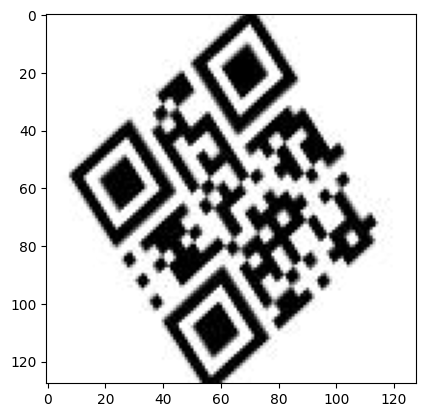

In [4]:
import cv2
import os
datadir = '/content/drive/MyDrive/qr_augmented'
# iterating over just one element
for img in os.listdir(datadir):
        img_array = cv2.imread(os.path.join(datadir,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break

In [5]:
#generalising this technique for all other images
array = []
array_small =[]
from tqdm import tqdm
def create_training_data():
        for img in tqdm(list(os.listdir(datadir))):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(datadir+'/'+img ,cv2.IMREAD_COLOR)  # convert to array
                new_array = cv2.resize(img_array, (128, 128))  # resize to normalize data size
                array.append([new_array])
                array_small.append([cv2.resize(img_array, (32,32),
                               interpolation=cv2.INTER_AREA)]) # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
create_training_data()

100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


In [8]:
len(array)

1999

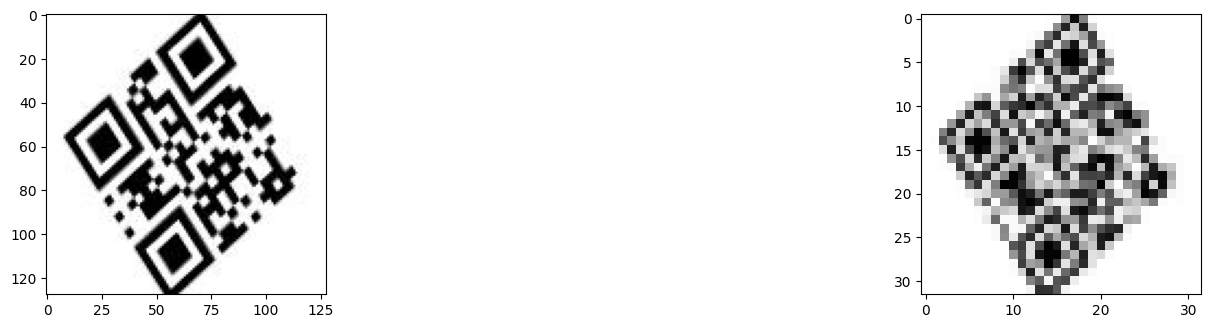

In [9]:
X =  []
Xs = []
for features in array:
    X.append(features)
for features in array_small:
    Xs.append(features)
plt.figure(figsize=(16, 8))
X = np.array(X).reshape(-1, 128, 128, 3)
Xs = np.array(Xs).reshape(-1, 32, 32, 3)
plt.subplot(231)
plt.imshow(X[0], cmap = 'gray')
plt.subplot(233)
plt.imshow(Xs[0], cmap = 'gray')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train, y_valid = train_test_split(Xs, X, test_size = 0.33, random_state = 12)
X_train.shape

(5, 32, 32, 3)

In [11]:
from main import *

In [12]:
# the generator and discriminator models are taken from main.py
hr_shape = (y_train.shape[1], y_train.shape[2], y_train.shape[3])
lr_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = generator(lr_ip, res_range = 16, upscale_range=2)
generator.summary()

discriminator = discriminator(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [13]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [14]:
#preparing the data batches
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(y_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(y_train[start_idx:end_idx])
    train_lr_batches.append(X_train[start_idx:end_idx])

In [15]:
epochs = 3
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 222ms/step


 20%|██        | 1/5 [00:29<01:58, 29.69s/it]

1/1 [==============================] - 0s 135ms/step


 40%|████      | 2/5 [00:37<00:49, 16.55s/it]

1/1 [==============================] - 0s 137ms/step


 60%|██████    | 3/5 [00:42<00:22, 11.32s/it]

1/1 [==============================] - 0s 136ms/step


 80%|████████  | 4/5 [00:47<00:08,  8.91s/it]

1/1 [==============================] - 0s 253ms/step


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


epoch: 1 g_loss: 4892415.45 d_loss: [4.66827391 0.7       ]


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 136ms/step


 20%|██        | 1/5 [00:07<00:31,  7.77s/it]

1/1 [==============================] - 0s 131ms/step


 40%|████      | 2/5 [00:15<00:23,  7.74s/it]

1/1 [==============================] - 0s 133ms/step


 60%|██████    | 3/5 [00:20<00:13,  6.51s/it]

1/1 [==============================] - 1s 542ms/step


 80%|████████  | 4/5 [00:29<00:07,  7.64s/it]

1/1 [==============================] - 0s 261ms/step


100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


epoch: 2 g_loss: 3613732.35 d_loss: [16.68025055  0.9       ]


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 232ms/step


 20%|██        | 1/5 [00:06<00:27,  6.93s/it]

1/1 [==============================] - 0s 131ms/step


 40%|████      | 2/5 [00:12<00:17,  5.84s/it]

1/1 [==============================] - 0s 128ms/step


 60%|██████    | 3/5 [00:18<00:12,  6.01s/it]

1/1 [==============================] - 0s 131ms/step


 80%|████████  | 4/5 [00:23<00:05,  5.91s/it]

1/1 [==============================] - 0s 130ms/step


100%|██████████| 5/5 [00:29<00:00,  5.83s/it]

epoch: 3 g_loss: 3397027.05 d_loss: [0. 1.]


1/1 [==============================] - 1s 1s/step


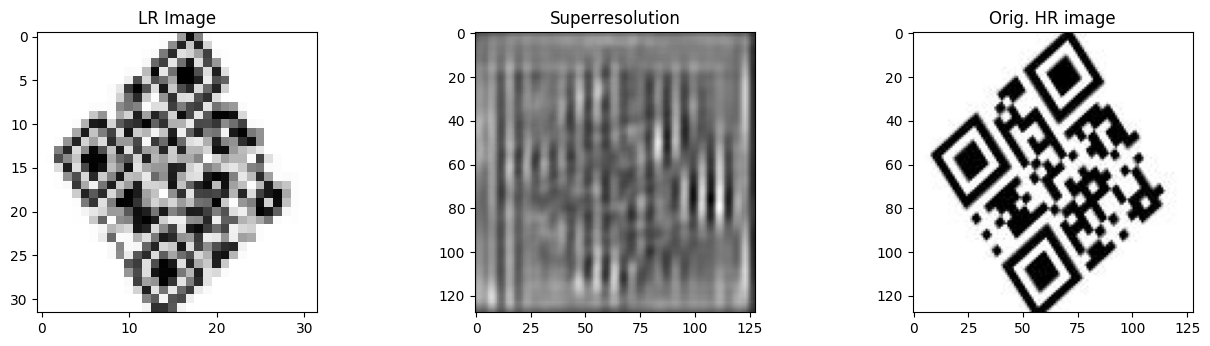

In [16]:
from keras.models import load_model
from numpy.random import randint

[X1, X2] = [X_valid, y_valid]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:], cmap = 'gray')
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(cv2.cvtColor(gen_image[0,:,:,:], cv2.COLOR_BGR2GRAY),cmap = 'gray')
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:], cmap = 'gray')

plt.show()